In [60]:
import sys

sys.path.append("../")

In [61]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import data.drawings.make_tasks as drawing_tasks
from src.analysis_utilities import SynthesisExperimentAnalyzer
from src.config_builder import ExperimentType

In [63]:
sns.set_theme(style="whitegrid", font_scale=1.25, rc={'figure.figsize':(12, 8)})

In [64]:
%config InlineBackend.figure_format = 'retina'

In [65]:
# EXPERIMENT_NAME = "benchmarks"
EXPERIMENT_NAME = "test_benchmarks_temp"
DOMAIN = "re2"
COMPUTE_LIKELIHOODS = False

FIGURES_DIR = os.path.join("figures", EXPERIMENT_NAME)
FIGURES_DOMAIN_DIR = os.path.join("figures", EXPERIMENT_NAME, DOMAIN)
os.makedirs(FIGURES_DOMAIN_DIR, exist_ok=True)

In [66]:
analyzer = SynthesisExperimentAnalyzer(
    experiment_name=EXPERIMENT_NAME,
    allow_incomplete_results=True,
    compute_likelihoods=COMPUTE_LIKELIHOODS,
)

Experiment directory: ../experiments_iterative/outputs/test_benchmarks_temp
Available domains: ['re2']


# Desired analyses
- num tasks solved in train/test per laps iteration
- num task solved vs. search time

### Tasks solved vs. LAPS iteration

In [71]:
df = analyzer.get_synthesis_results_for_domain(DOMAIN)
df

,request,task,programs,best_search_time,split,seed,iteration,experiment_type
0,"{'constructor': '->', 'arguments': [{'construc...",re2_train_0_if_the_word_ends_with_any_letter_a...,[{'program': '(lambda (_rflatten (_rappend _w ...,8.426642,train,0,0,enumeration_codex_stitch
1,"{'constructor': '->', 'arguments': [{'construc...",re2_train_1_if_there_is_consonant_replace_that...,[],NaN,train,0,0,enumeration_codex_stitch
2,"{'constructor': '->', 'arguments': [{'construc...",re2_train_2_if_the_word_ends_with_consonant_s_...,[],NaN,train,0,0,enumeration_codex_stitch
3,"{'constructor': '->', 'arguments': [{'construc...",re2_train_3_if_there_is_d_replace_that_with_y,[],NaN,train,0,0,enumeration_codex_stitch
4,"{'constructor': '->', 'arguments': [{'construc...",re2_train_4_if_there_is_b_add_k_before_that,[],NaN,train,0,0,enumeration_codex_stitch
...,...,...,...,...,...,...,...,...
2968,"{'constructor': '->', 'arguments': [{'construc...",re2_test_495_if_there_is_vowel_n_replace_that_...,[],NaN,test,0,2,enumeration_codex_stitch
2969,"{'constructor': '->', 'arguments': [{'construc...",re2_test_496_if_the_word_ends_with_any_letter_...,[{'program': '(lambda (#(lambda (lambda (#(lam...,6.269893,test,0,2,enumeration_codex_stitch
2970,"{'constructor': '->', 'arguments': [{'construc...",re2_test_497_if_the_word_starts_with_any_lette...,[{'program': '(lambda (#(lambda (lambda (#(lam...,5.443366,test,0,2,enumeration_codex_stitch
2971,"{'constructor': '->', 'arguments': [{'construc...",re2_test_498_if_there_is_vowel_r_add_u_before_...,[],NaN,test,0,2,enumeration_codex_stitch


In [72]:
df_results = (
    df.groupby(["experiment_type", "seed", "iteration", "split"])
    .best_search_time.count()
    .reset_index(name="n_solved")
)

# Duplicate "benchmark_enumeration" for n_iterations
df_list = [df_results[df_results.experiment_type != "enumeration"]]
for iteration in sorted(df_results.iteration.unique()):
    df_tmp = df_results[df_results.experiment_type == "enumeration"].copy()
    df_tmp["iteration"] = iteration
    df_list.append(df_tmp)
df_results = pd.concat(df_list, axis=0).reset_index(drop=True)

df_results

,experiment_type,seed,iteration,split,n_solved
0,enumeration_codex_stitch,0,0,test,96
1,enumeration_codex_stitch,0,0,train,31
2,enumeration_codex_stitch,0,1,test,96
3,enumeration_codex_stitch,0,1,train,70
4,enumeration_codex_stitch,0,2,test,96
5,enumeration_codex_stitch,0,2,train,70


<AxesSubplot:xlabel='iteration', ylabel='n_solved'>

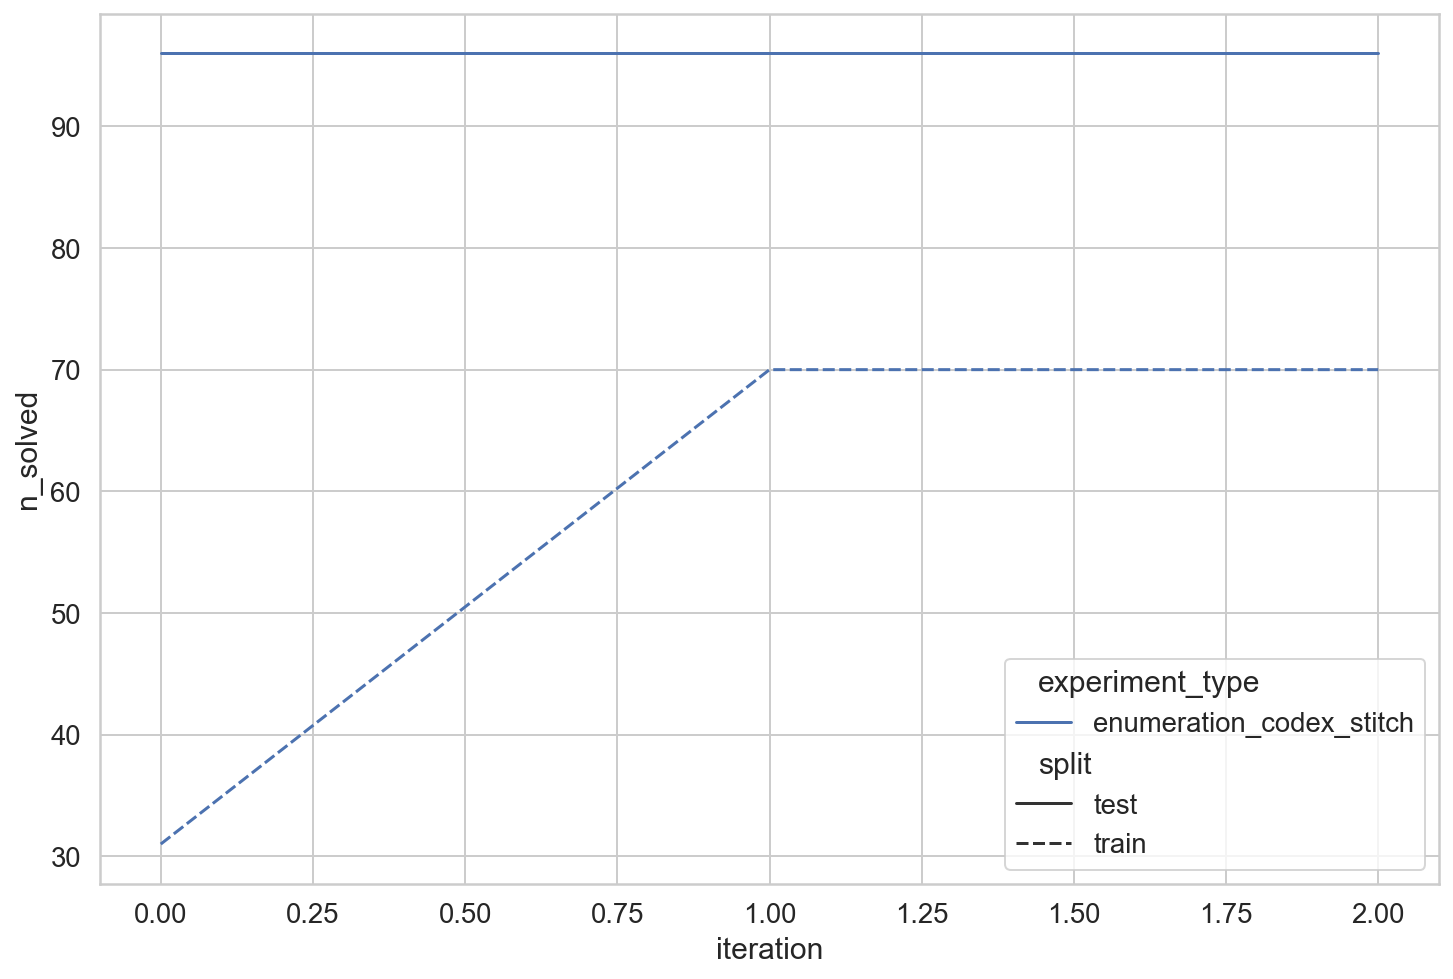

In [73]:
sns.lineplot(
    data=df_results, x="iteration", y="n_solved", hue="experiment_type", style="split"
)

### Tasks solved vs. search time

In [74]:
df_search_time = analyzer.get_search_time_results_for_domain(DOMAIN)
df_search_time

Using enumeration_timeout: 120


,time,n_solved,experiment_type,seed,iteration,split
0,0,0,enumeration_codex_stitch,0,0,test
1,1,0,enumeration_codex_stitch,0,0,test
2,2,0,enumeration_codex_stitch,0,0,test
3,3,0,enumeration_codex_stitch,0,0,test
4,4,2,enumeration_codex_stitch,0,0,test
...,...,...,...,...,...,...
721,116,70,enumeration_codex_stitch,0,2,train
722,117,70,enumeration_codex_stitch,0,2,train
723,118,70,enumeration_codex_stitch,0,2,train
724,119,70,enumeration_codex_stitch,0,2,train


<AxesSubplot:xlabel='time', ylabel='n_solved'>

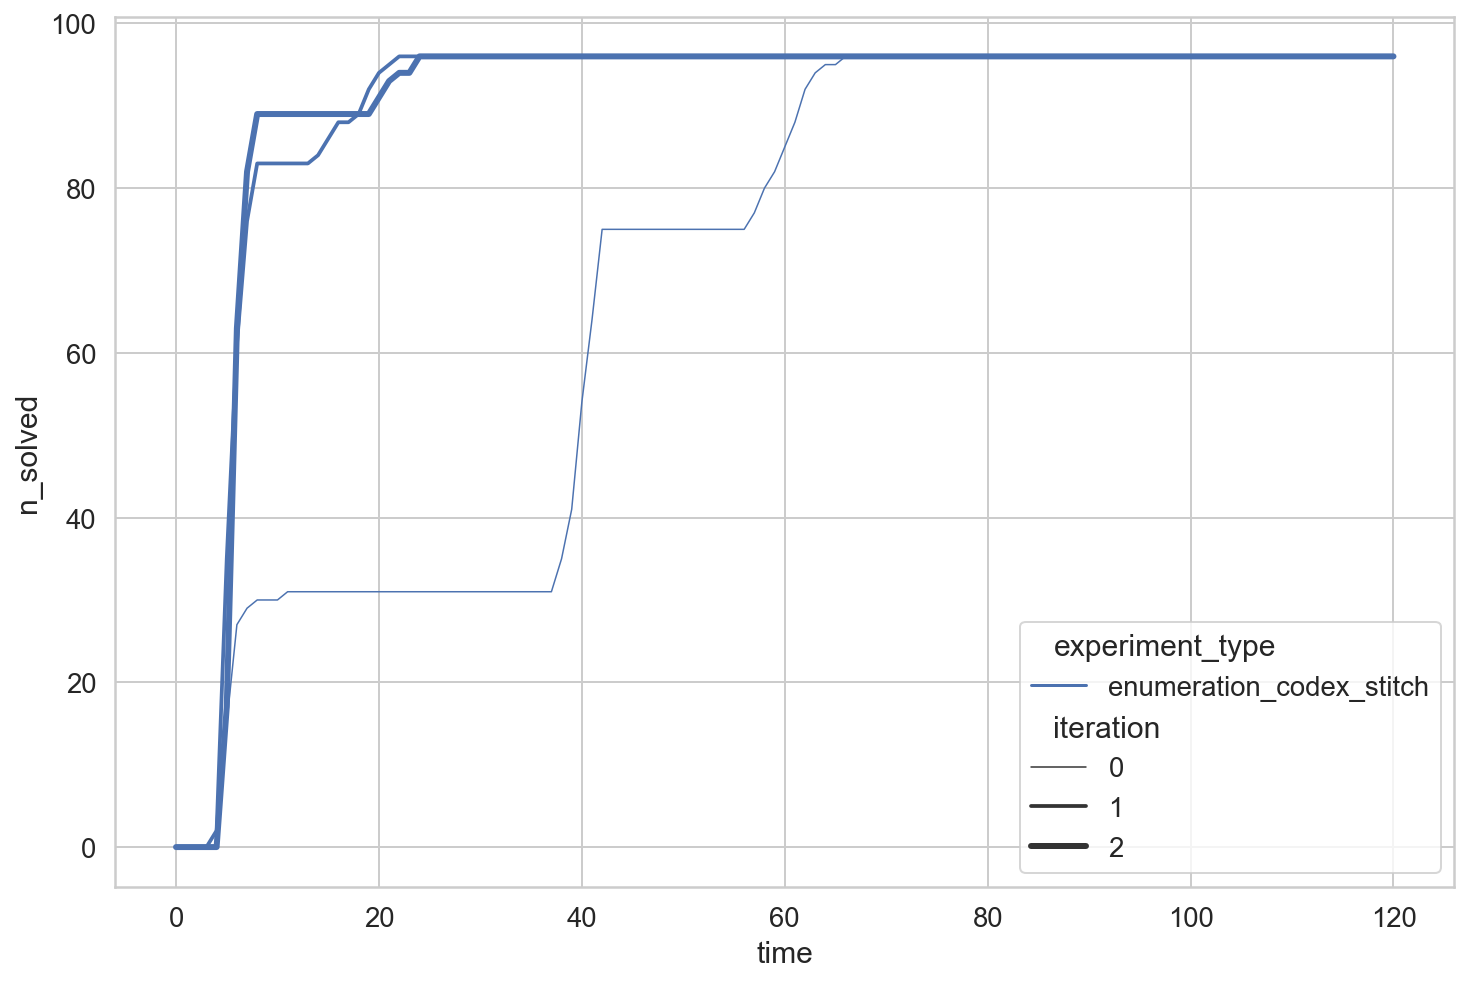

In [75]:
sns.lineplot(
    data=df_search_time[df_search_time.split == "test"],
    x="time",
    y="n_solved",
    hue="experiment_type",
    size="iteration"
)

<AxesSubplot:xlabel='time', ylabel='n_solved'>

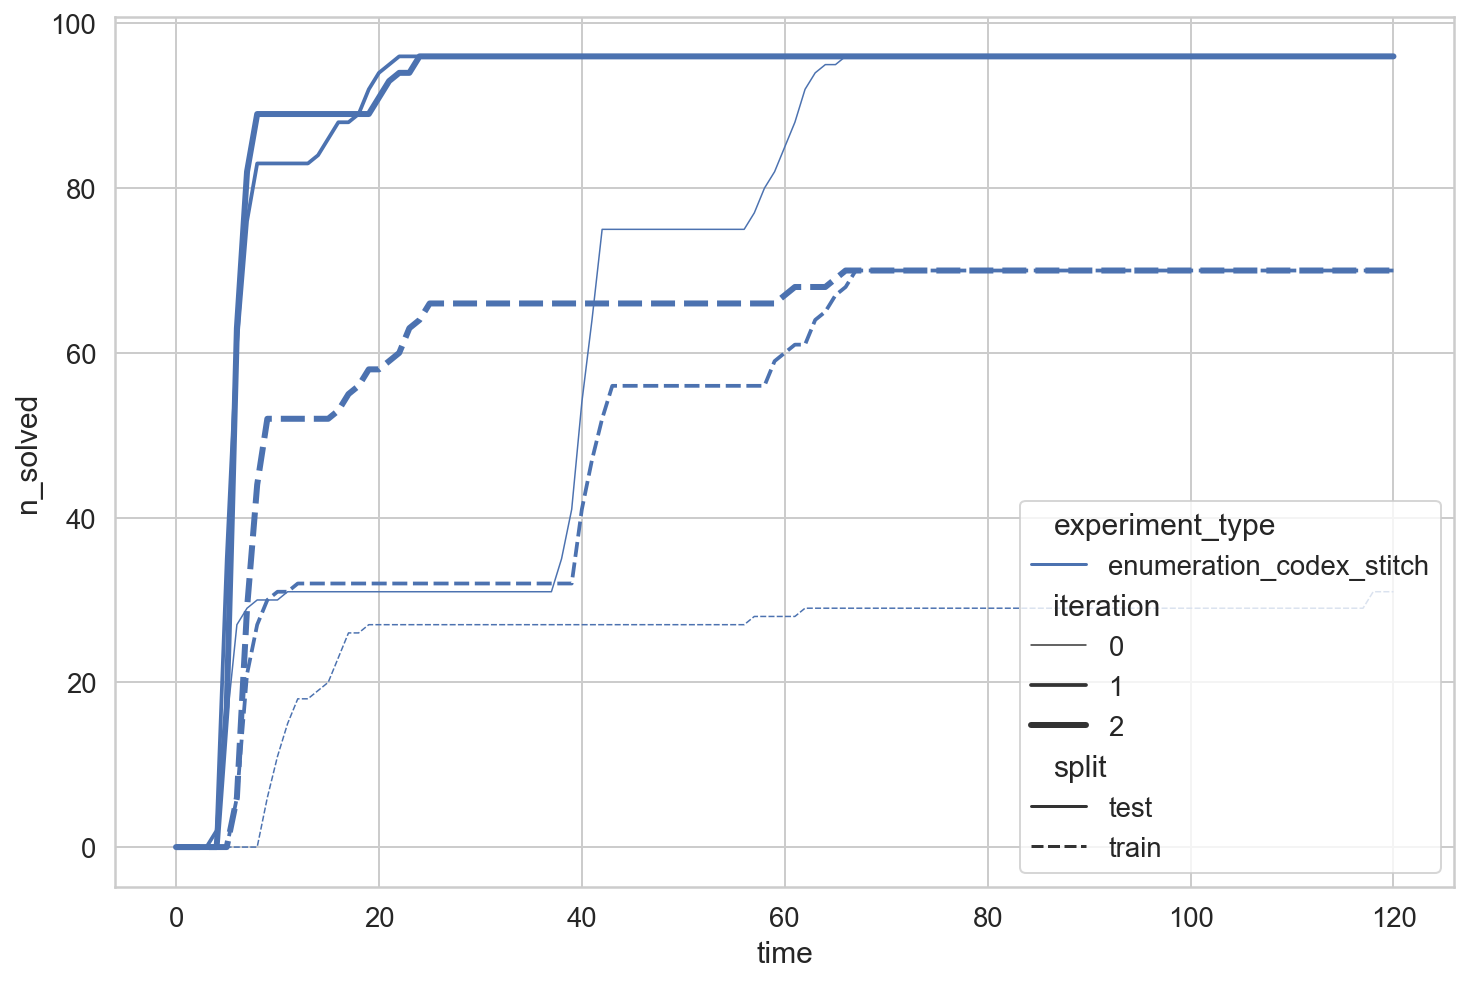

In [70]:
sns.lineplot(
    data=df_search_time,
    x="time",
    y="n_solved",
    hue="experiment_type",
    style="split",
    size="iteration",
)